# Train Transformer model

# Prepare ENV/Load libraries

## Mount Google Drive

In [1]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
google_drive_path = "/content/gdrive/MyDrive/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# change directory to the project path

project_path = os.path.join(google_drive_path, "Colab Notebooks/SER/")
os.chdir(project_path)
os.listdir("./")

['utils',
 'fonts',
 'meta_data',
 'dataset',
 '.git',
 '.env',
 'libs',
 'README.md',
 'models',
 'logs',
 'SER Model idea.drawio',
 'deprecated',
 'Data distribution.ipynb',
 'Notebook Template.ipynb',
 'Preprocess Json to CSV.ipynb',
 '.gitignore',
 'Experiment Preprocessing.ipynb',
 'Notebook Template Train.ipynb',
 'Untitled0.ipynb',
 'Train Multi-layer Transformer.ipynb']

## Install libraries

In [3]:
# !rm -rf tmp && git clone https://github.com/chuan-khuna/my-python-utils.git tmp && cp -R tmp/utils ./ && cp -R tmp/fonts ./ && rm -rf tmp

In [4]:
!python3 --version

Python 3.8.16


Install latest tensorflow version

In [5]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf2onnx 1.13.0 requires flatbuffers<3.0,>=1.12, but you have flatbuffers 22.12.6 which is incompatible.
onnx 1.13.0 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.


In [6]:
!pip install matplotlib seaborn -Uq
!pip install pythainlp -q
!pip install keras-tuner -q
!pip install pyYAML -q
!pip install tensorflow-io[tensorflow] tf2onnx onnxruntime -Uq

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.11.0 requires tensorflow<2.12,>=2.11.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.9.0 which is incompatible.


In [7]:
%load_ext tensorboard

# Import Libraries

In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import patheffects
import seaborn as sns

import json
import yaml
import re
from tqdm.notebook import trange, tqdm

import datetime

import tf2onnx
import onnx
import onnxruntime as rt

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras_tuner
import tensorflow_io as tfio

seed_ = 20200218
tf.random.set_seed(seed_)
np.random.seed(seed_)

from sklearn.metrics import confusion_matrix, classification_report

In [10]:
from utils.vis_utils import *

font_dir = [f"{google_drive_path}/code_assets/fonts/"]
mpl_import_fonts(font_dir)

In [11]:
from libs.audio_preprocessing import AudioPreprocessor
from utils.tf_layers.transformer_arch.embedding import FixedPositionalEncoding
from utils.tf_layers.transformer_arch.transformer import TransformerEncoderBlock, TransformerDecoderBlock

## Ensure that matplotlib can use subplot mosaic

In [12]:
def check_version(version_str, major, minor):
    print(version_str)
    version = [int(i) for i in version_str.split('.')]
    assert version[0] >= major and version[1] >= minor

check_version(matplotlib.__version__, 3, 6)
check_version(sns.__version__, 0, 12)

del check_version

matplotlib.__version__, sns.__version__, tf.__version__

3.6.2
0.12.2


('3.6.2', '0.12.2', '2.9.0')

## View hardware spec

In [13]:
!nvidia-smi

Sun Jan  1 11:51:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
tf.config.list_physical_devices('GPU')

for device in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)

In [15]:
def get_timestamp():
    return datetime.datetime.strftime(datetime.datetime.now(), "%Y%m%d-%H%M")

get_timestamp()

'20230101-1151'

# Load Dataset

Copy dataset from Google Drive to VM storage

In [16]:
# !rm -rf /content/dataset/

In [17]:
def unzip_dataset(zipfile, target_loc):
    """Unzip a zip file from google drive to VM storage

    I hypothesise that Google Drive has some limits to read files.
    So I decided to extract file to VM storage instead

    ```python
    target_loc = dataset_path = "/content/dataset/"
    ```

    Args:
        zipfile (str): _description_
        target_loc (str): target root folder to place content in the zip file.
    """

    # create root path to store the dataset
    if not os.path.exists(target_loc):
        os.makedirs(target_loc, exist_ok=True)

    subfolder = zipfile.split('/')[-1].split('.zip')[0]
    target_path = os.path.join(target_loc, subfolder)
    print(f"Unzip {zipfile} to {target_path}")
    os.system(f"unzip {zipfile} -d {target_path}")

path_to_zipfiles = "./dataset/"
dataset_path = "/content/dataset/"

if not(os.path.exists(dataset_path) and len(os.listdir(dataset_path)) == 10):
    for filename in os.listdir(path_to_zipfiles):
        if filename.endswith(".zip"):
            zip_path = os.path.join(path_to_zipfiles, filename)
            unzip_dataset(zip_path, dataset_path)

print(os.listdir(dataset_path))

['studio11-20', 'studio1-10', 'studio31-40', 'studio41-50', 'zoom1-10', 'studio51-60', 'studio71-80', 'studio61-70', 'zoom11-20', 'studio21-30']


In [18]:
df = pd.read_csv("./meta_data/dataset.csv")

# drop emotion label that tagged as None
df = df[df['majority_emo'] != 'None']
df = df[df['majority_emo'] != 'other']

# drop corrupted files
df = df[df['duration'] > 0]

df = df[df['agreement'] >= 0.5]

# shuffle
df = df.sample(frac=1)

In [19]:
assert (df['duration'] > 0).all()
df['majority_emo'].drop_duplicates()

10460    Frustrated
5293          Angry
27635       Neutral
24610         Happy
3849            Sad
Name: majority_emo, dtype: object

# Preprocess label 

- Create one-hot encoding
- Calculate class weight

In [20]:
label_col = "majority_emo"
df = df.join(pd.get_dummies(df[label_col]))

In [21]:
classes = list(pd.get_dummies(df[label_col]).columns)
num_classes = len(classes)
classes

['Angry', 'Frustrated', 'Happy', 'Neutral', 'Sad']

In [22]:
class_weight = {}
for i, c in enumerate(classes):
    class_size = (df[label_col] == c).sum()
    class_weight[i] = np.round(1/class_size * len(df)/2.0, 3)

class_weight

{0: 3.997, 1: 1.61, 2: 3.075, 3: 1.71, 4: 4.572}

# Visualise dataset examples

Load audio preprocessor

In [23]:
prep = AudioPreprocessor()

In [24]:
def plot_wave(tensor, max_length=32000):
    fig = plt.figure(figsize=(8, 3), dpi=80)

    length = tf.shape(tensor).numpy()[0]
    if length > max_length:
        length = max_length

    sns.lineplot(tensor.numpy()[:length], linewidth=0.5)
    plt.ylim([-1, 1])
    plt.show()

def plot_spec(tensor, transpose=True, max_length=256):
    fig = plt.figure(figsize=(9, 3), dpi=80)
    
    try:
        arr = tensor.numpy()
    except:
        arr = tensor

    if transpose:
        arr = arr.T

    length = arr.shape[1]
    if length > max_length:
        length = max_length

    sns.heatmap(arr[:, :length], vmin=-40, vmax=40)
    plt.show()

# Prepare Dataset

In [25]:
def preprocess_xy(x, y):
    audio, spec = prep.preprocess(x)
    return spec, y

In [26]:
ds = tf.data.Dataset.from_tensor_slices((df['path'], df[classes]))
ds = ds.map(preprocess_xy)

(1875, 128) [0 1 0 0 0]


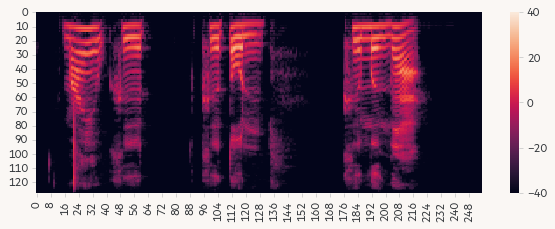

(1875, 128) [0 1 0 0 0]


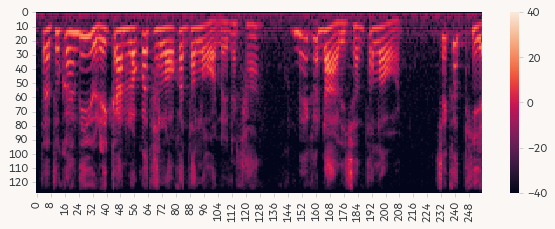

(1875, 128) [1 0 0 0 0]


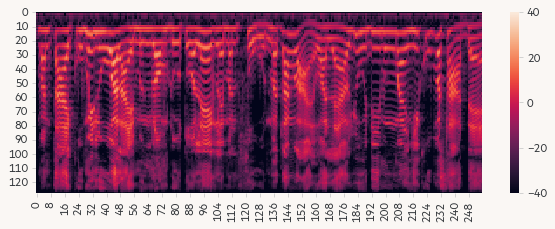

In [27]:
for x, y in ds.take(3).as_numpy_iterator():
    print(x.shape, y)
    plot_spec(x)

## Split Train/Val/Test

In [28]:
TRAIN_SIZE, VAL_SIZE = 0.7, 0.2

TRAIN_SIZE, VAL_SIZE = int(TRAIN_SIZE*len(df)), int(VAL_SIZE*len(df))
TEST_SIZE = len(df) - (TRAIN_SIZE + VAL_SIZE)
TRAIN_SIZE, VAL_SIZE, TEST_SIZE

(16998, 4856, 2430)

In [29]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16
SHUFFLE_SIZE = 500

# split train-validation
train_ds = ds.shuffle(SHUFFLE_SIZE, seed=seed_, reshuffle_each_iteration=False).take(TRAIN_SIZE)
val_ds = ds.shuffle(SHUFFLE_SIZE, seed=seed_,
                    reshuffle_each_iteration=False).skip(TRAIN_SIZE).take(VAL_SIZE)
test_ds = ds.shuffle(SHUFFLE_SIZE, seed=seed_,
                     reshuffle_each_iteration=False).skip(TRAIN_SIZE + VAL_SIZE).take(TEST_SIZE)

# prepare to train
train_ds = train_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

# Model

## Building blocks

In [30]:
class Encoder(tf.keras.layers.Layer):

    def __init__(self,
                 num_layers,
                 num_heads,
                 embedding_dim,
                 dense_dim,
                 pos_encoding_length,
                 dropout_rate=0.1):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dense_dim = dense_dim

        self.pos_encoding = FixedPositionalEncoding(seq_length=pos_encoding_length,
                                                    embed_dim=self.embedding_dim)

        self.encoders = [
            TransformerEncoderBlock(embedding_dim=self.embedding_dim,
                                    num_heads=self.num_heads,
                                    dense_dim=self.dense_dim,
                                    dropout_rate=dropout_rate) for _ in range(self.num_layers)
        ]

        self.attn_scores = None
        self.pos_enc_dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # add positional encoding to spectrogram features
        x = self.pos_encoding(x)
        x = self.pos_enc_dropout(x)
        for i in range(self.num_layers):
            x = self.encoders[i](x)
        self.attn_scores = self.encoders[-1].attn_scores

        return x


class SERTransformerModel(tf.keras.Model):

    def __init__(self, *, input_shape, num_conv_layers, conv_filter_size, conv_kernel_size,
                 num_encoder_layers, num_heads, dense_dim, pos_encoding_length, dropout_rate,
                 dense_out):

        super().__init__()

        self.conv = tf.keras.models.Sequential([
            tf.keras.layers.InputLayer(input_shape=input_shape),
            tf.keras.layers.Conv1D(conv_filter_size, conv_kernel_size),
            tf.keras.layers.MaxPool1D()
        ])

        for _ in range(num_conv_layers - 1):
            self.conv.add(tf.keras.layers.Conv1D(conv_filter_size, conv_kernel_size))
            self.conv.add(tf.keras.layers.MaxPool1D())

        self.embedding_dim = self.conv.output.shape[-1]

        self.encoder = Encoder(num_layers=num_encoder_layers,
                               num_heads=num_heads,
                               embedding_dim=self.embedding_dim,
                               pos_encoding_length=pos_encoding_length,
                               dense_dim=dense_dim,
                               dropout_rate=dropout_rate)
        self.global_avg = tf.keras.layers.GlobalAveragePooling1D()
        self.dense_out = dense_out

        self.attn_scores = None

    def call(self, x):
        x = self.conv(x)
        x = self.encoder(x)
        self.attn_scores = self.encoder.attn_scores
        x = self.global_avg(x)
        x = self.dense_out(x)
        return x

## Get the shape of preprocessed audio

In [31]:
for mel_spec, label in ds.take(3):
    print(mel_spec.shape, label)

(1875, 128) tf.Tensor([0 1 0 0 0], shape=(5,), dtype=uint8)
(1875, 128) tf.Tensor([0 1 0 0 0], shape=(5,), dtype=uint8)
(1875, 128) tf.Tensor([1 0 0 0 0], shape=(5,), dtype=uint8)


In [32]:
spec_length, spec_features = mel_spec.shape
spec_length, spec_features

(1875, 128)

## Initialise model

In [33]:
timestamp = get_timestamp()
timestamp

'20230101-1151'

In [34]:
dense_out = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [35]:
model = SERTransformerModel(
    input_shape=(spec_length, spec_features),
    num_conv_layers=4,
    conv_filter_size=64,
    conv_kernel_size=5,
    num_encoder_layers=2,
    num_heads=8,
    dense_dim=128,
    pos_encoding_length=4096,
    dropout_rate=0.1,
    dense_out=dense_out
)

In [36]:
model(mel_spec[np.newaxis])

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.17783846, 0.15837255, 0.15159605, 0.17200036, 0.3401926 ]],
      dtype=float32)>

## Compile/Callbacks

In [37]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0,
                               beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
model.summary(expand_nested=True)

Model: "ser_transformer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 113, 64)           102656    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv1d (Conv1D)           (None, 1871, 64)          41024     |
|                                                               |
| max_pooling1d (MaxPooling1D  (None, 935, 64)        0         |
| )                                                             |
|                                                               |
| conv1d_1 (Conv1D)         (None, 931, 64)           20544     |
|                                                               |
| max_pooling1d_1 (MaxPooling  (None, 465, 64)        0         |
| 1D)                                                           |
|                                                               |
| conv1d_2 (Conv1D)         (None, 461, 64)  

In [39]:
tensorboard_log = "logs/tb_logs"

In [40]:
# !rm -rf {tensorboard_loc}

In [41]:
log_dir = os.path.join(tensorboard_log, timestamp)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

monitoring_metric = 'val_loss'
metric_delta = 0.001
early_stop = tf.keras.callbacks.EarlyStopping(monitor=monitoring_metric,
                                            patience=16,
                                            min_delta=metric_delta)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitoring_metric,
                                                patience=12,
                                                min_delta=metric_delta,
                                                cooldown=8,
                                                min_lr=1e-8)
checkpoint_filepath = f'./models/{timestamp}/checkpoint'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath,
                                                monitor=monitoring_metric,
                                                save_best_only=True)

In [ ]:
hist = model.fit(train_ds, epochs=32, 
                 validation_data=val_ds,
                 class_weight=class_weight,
                 callbacks=[tensorboard_callback, early_stop, reduce_lr, checkpoint])

Epoch 1/32
 564/1063 [==============>...............] - ETA: 7:34 - loss: 4.0612 - accuracy: 0.1752

In [ ]:
model.save(f'./models/{timestamp}/final')

# Model Report

In [ ]:
%tensorboard --logdir {tensorboard_log}

In [ ]:
if not os.path.exists("./models/"):
    os.makedirs("./models/", exist_ok=True)

In [ ]:
prep.save_setting(f"./models/{timestamp}/setting.json")

In [ ]:
def my_model_report(hist,
                    metrics,
                    labels_dict,
                    conf_ticks,
                    fig_title="",
                    save_path="",
                    row_h=2.5,
                    dpi=100):

    # extract metrics in tensorflow's hist obj
    metrics_in_hist = []
    for k in hist.history.keys():
        if not k.startswith('val_'):
            metrics_in_hist.append(k)
    metrics = [metric for metric in metrics if metric in metrics_in_hist]

    # create plot template
    fig_h = (len(metrics) + 1) * row_h
    conf_mosaic = [['conf_train', 'conf_val', 'conf_test']]
    fig_mosaic = [[metric] * 3 for metric in metrics]
    fig, axs = plt.subplot_mosaic(fig_mosaic + conf_mosaic, figsize=(fig_h, fig_h), dpi=dpi)

    plt.suptitle(fig_title)

    # plot epoch history
    epochs = hist.epoch
    for metric in metrics:
        sns.lineplot(x=epochs, y=hist.history[metric], label=metric, ax=axs[metric])

        val_metric = 'val_' + metric
        if val_metric in hist.history.keys():
            sns.lineplot(x=epochs, y=hist.history[val_metric], label=val_metric, ax=axs[metric])
            axs[metric].grid(True, alpha=0.2)

    # plot confusion matrix
    valid_keys = ['train', 'val', 'test']
    for k in list(labels_dict.keys()):
        if k in valid_keys:
            data = labels_dict[k]
            if 'true' in list(data.keys()) and 'pred' in list(data.keys()):
                true_labels = data['true']
                pred_labels = data['pred']
                sns.heatmap(confusion_matrix(true_labels, pred_labels),
                            annot=True,
                            fmt='d',
                            square=True,
                            cbar=False,
                            ax=axs[f'conf_{k}'],
                            xticklabels=conf_ticks,
                            yticklabels=conf_ticks)
                axs[f'conf_{k}'].set_title(f'confusion matrix {k}')

    for k in valid_keys:
        if k not in list(labels_dict.keys()):
            axs[f'conf_{k}'].axis('off')

    axs['conf_train'].set_title('confusion matrix train')
    axs['conf_train'].set_xlabel('pred')
    axs['conf_train'].set_ylabel('actual')

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=dpi*2)
    plt.show()

In [ ]:
train_labels = [label for x, label in (train_ds.take(-1).as_numpy_iterator())]
val_labels = [label for x, label in (val_ds.take(-1).as_numpy_iterator())]
test_labels = [label for x, label in (test_ds.take(-1).as_numpy_iterator())]

train_labels = np.argmax(np.concatenate(train_labels), axis=-1)
val_labels = np.argmax(np.concatenate(val_labels), axis=-1)
test_labels = np.argmax(np.concatenate(test_labels), axis=-1)

pred_train_labels = np.argmax(model.predict(train_ds), axis=-1)
pred_val_labels = np.argmax(model.predict(val_ds), axis=-1)
pred_test_labels = np.argmax(model.predict(test_ds), axis=-1)

In [ ]:
metrics = ['loss', 'accuracy']

labels_dict = {
    'train': {
        'true': train_labels,
        'pred': pred_train_labels
    },
    'val': {
        'true': val_labels,
        'pred': pred_val_labels
    },
    'test': {
        'true': test_labels,
        'pred': pred_test_labels
    }
}

ticks = classes

fig_title = f"{timestamp} | {len(train_labels)}/{len(val_labels)}/{len(test_labels)}"
save_path = f"./models/{timestamp}.jpg"

my_model_report(hist,
                metrics,
                labels_dict,
                ticks,
                fig_title=fig_title,
                save_path=save_path,
                row_h=3.5)